## Generating Model Resonant Emission Line Profiles with OutLines

If `OutLines` is not installed, this can be done using `pip install SpecOutLines` in terminal or directly below. Using `pip` will automatically handle any dependencies. Detailed documentation is available at https://github.com/sflury/OutLines

In [1]:
%pip install SpecOutLines

mambajs 0.19.7

Process pip requirements ...

Requirement numpy already satisfied.
Requirement scipy already satisfied.
Requirement matplotlib already satisfied.


Start by importing the `OutLines` code and related basic packages.

In [2]:
import OutLines as OL
import numpy as np
import matplotlib.pyplot as plt

/lib/python3.13/site-packages/OutLines/__absorption__.py:1: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.5)
  from scipy.integrate import fixed_quad
/lib/python3.13/site-packages/OutLines/__params__.py:54: SyntaxWarning: invalid escape sequence '\s'
  'Pulses':['$\sigma_x$','$\Delta x$','$x_0$'],\
/lib/python3.13/site-packages/OutLines/__params__.py:54: SyntaxWarning: invalid escape sequence '\D'
  'Pulses':['$\sigma_x$','$\Delta x$','$x_0$'],\
/lib/python3.13/site-packages/OutLines/__params__.py:55: SyntaxWarning: invalid escape sequence '\s'
  'DampedPulses':[r'$\gamma$','$\sigma_x$','$\Delta x$','$x_0$'],\
/lib/python3.13/site-packages/OutLines/__params__.py:55: SyntaxWarning: invalid escape sequence '\D'
  'DampedPulses':[r'$\gamma$','$\sigma_x$','$\Delta x$','$x_0$'],\
/lib/python3.13/site-packages/OutLines/__params__.py:56: SyntaxWarning: invalid escape sequence '\s'
  'DampedPulsesLog':[r'$\gamma$','$\sigma_x$','$\D

To create a model for specific resonant emission lines, call the `OutLines.Resonant` class. Doing so constructs and instantiates the line profile object, which you can use to generate line profiles, view settings and parameters, update parameters, and pass the model to various fitters for modeling.

When creating a model, atomic data must be provided for the feature(s) in question. For resonant emission lines, the data include the rest wavelength of the transition, the oscilator strength, and the escape probability given by the transition probability given by $A_i/\sum A$. Below is an example for the Mg II doublet using atomic data from NIST.

In [3]:
wave = np.array([2797.998,2802.704])
fosc = np.array([0.844,0.303])
pesc =  np.array([4.79/(4.79+2.57),2.57/(4.79+2.57)])
model = OL.Resonant(wave,fosc,pesc)

Now you have a model with the default settings prescribed by the `OutLines` code! To view the settings, try calling the methods bound to the model object as below.

In [4]:
model.print_settings()

   ------------------------------------
  |           MODEL SETTINGS           |
   ------------------------------------
  |     Line   1     : 2797.998        |
  |     Line   2     : 2802.704        |
  |          Profile : Resonant        |
  |    VelocityField : BetaCAK         |
  |   DensityProfile : PowerLaw        |
  |         Geometry : Spherical       |
  |  StaticComponent : No              |
  |         FromRest : Yes             |
  |         Aperture : No              |
  |             Disk : No              |
   ------------------------------------


As you can see, the default assumption is a spherical geometry with a power law density gradient and a velocity gradient based on CAK theory for winds. To change these assumptions requires building a new model. Suppose you want a system of shells mimicking a series of outflowing events or a wind in formation. The model specifications would look like the below.

In [6]:
model_pulses = OL.Resonant(wave,fosc,pesc,DensityProfile='DampedPulses')

The change in settings can be seen by calling the new model object's `settings()` method.

In [7]:
model_pulses.print_settings()

   ------------------------------------
  |           MODEL SETTINGS           |
   ------------------------------------
  |     Line   1     : 2797.998        |
  |     Line   2     : 2802.704        |
  |          Profile : Resonant        |
  |    VelocityField : BetaCAK         |
  |   DensityProfile : DampedPulses    |
  |         Geometry : Spherical       |
  |  StaticComponent : No              |
  |         FromRest : Yes             |
  |         Aperture : No              |
  |             Disk : No              |
   ------------------------------------


To view the default parameters associated with these models, you can call the `print_params()` method bound to the model.

In [8]:
model.print_params()
model_pulses.print_params()

   ------------------------------------
  |          MODEL PARAMETERS          |
   ------------------------------------
  |   TerminalVelocity :  299.792 km/s |
  |      VelocityIndex :    1.000      |
  |  LogColumnOutflow1 :   14.000      |
  |  LogColumnOutflow2 :   14.000      |
  |      PowerLawIndex :    2.000      |
   ------------------------------------
   ------------------------------------
  |          MODEL PARAMETERS          |
   ------------------------------------
  |   TerminalVelocity :  299.792 km/s |
  |      VelocityIndex :    1.000      |
  |  LogColumnOutflow1 :   14.000      |
  |  LogColumnOutflow2 :   14.000      |
  |          DecayRate :    0.100      |
  |         PulseWidth :    0.200      |
  |      PulseInterval :    1.000      |
  |         PulsePhase :    2.000      |
   ------------------------------------


To plot a model line profile, you can call the `get_profile()` method, passing it an arbitrary array of wavelengths. The function returns an array of numbers representing the line profile at the specified wavelengths for the parameters stored in the `model` object, which makes for easy plotting.

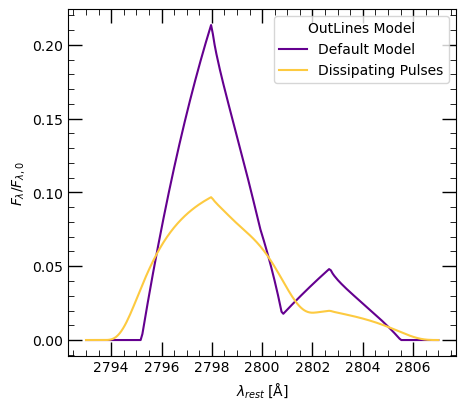

In [22]:
w = np.linspace(2793,2807,201)
plt.plot(w,model.get_profile(w),label='Default Model')
plt.plot(w,model_pulses.get_profile(w),label='Dissipating Pulses')
plt.xlabel(r'$\lambda_{rest}\rm\:[\AA]$')
plt.ylabel(r'$F_\lambda/F_{\lambda,0}$')
plt.legend(title='OutLines Model')

Updating the parameters in the model can be done using the `update_params()` method. Velocities can be passed in units of km s$^{-1}$ or in units of the speed of light. Column densities are in log(cm$^{-2}$). Multiple parameters can be updated at once. Printing the parameters will indicate that they have been updated and will also indicate the units where applicable.

In [23]:
model_pulses.update_params(['TerminalVelocity'],[500])
model_pulses.update_params(['DecayRate','PulseWidth'],[1,0.1])

Here is an example where the spatial width of each event is updated iteratively and plotted.

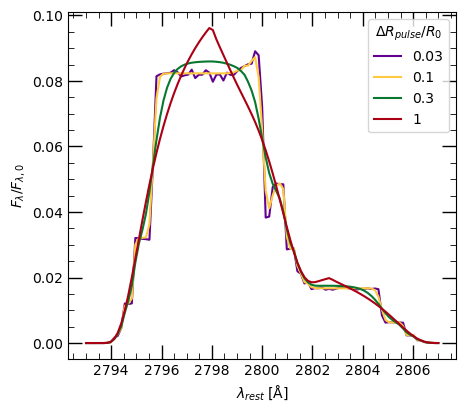

In [40]:
w = np.linspace(2793,2807,101)
for dr in [0.03,0.1,0.3,1]:
    model_pulses.update_params(['PulseWidth'],[dr])
    plt.plot(w,model_pulses.get_profile(w),label=str(dr))
plt.xlabel(r'$\lambda_{rest}\rm\:[\AA]$')
plt.ylabel(r'$F_\lambda/F_{\lambda,0}$')
plt.legend(title=r'$\Delta R_{pulse}/R_0$')